# 1 Import Libraries



In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# 2 Load Data

In [ ]:
# Mengambil file
file_path = 'household_power_consumption.txt'

# Mengambil data dari file
# Menggabungkan kolom Date & Time
df = pd.read_csv(file_path, sep=';', dayfirst=True,
                 infer_datetime_format=True,
                 low_memory=False, na_values=['nan', '?'])

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


# 3 Preprocess Data

In [ ]:
# Menggabungkan kolom Date & Time
df['Datetime'] = pd.to_datetime(df['Date'] + " " + df['Time'])

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
Datetime,,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [ ]:
df.to_csv('house_consumption_melted.csv', index=False)

# 4 Model Build

## Process Melted Dataset

In [ ]:
# Ambil Data
df = pd.read_csv('house_consumption_melted.csv', sep=',', infer_datetime_format=True, header=0)

# Convert 'Datetime' column to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Group by minute and then resample into 1-hour frequency while summing 'Sub_metering_3'
df_agg = df.resample('1H').agg({'Sub_metering_3': 'sum'})

df_agg

,Sub_metering_3
Datetime,
2006-12-16 17:00:00,607.0
2006-12-16 18:00:00,1012.0
2006-12-16 19:00:00,1001.0
2006-12-16 20:00:00,1007.0
2006-12-16 21:00:00,1033.0
...,...
2008-12-11 19:00:00,0.0
2008-12-11 20:00:00,0.0
2008-12-11 21:00:00,945.0


## Select the Relevant Data

In [ ]:
# Select relevant columns
data = df_agg[['Sub_metering_3']]

# Print the result
print(data)

                     Sub_metering_3
Datetime                           
2006-12-16 17:00:00           607.0
2006-12-16 18:00:00          1012.0
2006-12-16 19:00:00          1001.0
2006-12-16 20:00:00          1007.0
2006-12-16 21:00:00          1033.0
...                             ...
2008-12-11 19:00:00             0.0
2008-12-11 20:00:00             0.0
2008-12-11 21:00:00           945.0
2008-12-11 22:00:00           792.0
2008-12-11 23:00:00             0.0

[17431 rows x 1 columns]


## Normalize Data

In [ ]:
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

print(data_normalized)

[[0.50289975]
 [0.83844242]
 [0.82932891]
 ...
 [0.78293289]
 [0.65617233]
 [0.        ]]


## Create Sequences

In [ ]:
# Function to create input sequences and labels
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
BATCH_SIZE = 25
sequence_length = 24

# Create sequences and labels
X, y = create_sequences(data_normalized, sequence_length)

## Splits The Data

In [ ]:
split_time = int(len(data) * 0.8)
train_data, test_data = X[:split_time], X[split_time:]
train_target, test_target = y[:split_time], y[split_time:]

In [ ]:
# Reshape data for LSTM (samples, time steps, features)
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
train_target = train_target.reshape((train_target.shape[0], train_target.shape[1], 1))

array([[[0.50289975],
        [0.83844242],
        [0.82932891],
        ...,
        [0.90637945],
        [0.87986744],
        [0.85335543]],

       [[0.83844242],
        [0.82932891],
        [0.83429992],
        ...,
        [0.87986744],
        [0.85335543],
        [0.83595692]],

       [[0.82932891],
        [0.83429992],
        [0.85584093],
        ...,
        [0.85335543],
        [0.83595692],
        [0.83678542]],

       ...,

       [[0.92792046],
        [0.94366197],
        [0.93620547],
        ...,
        [0.07622204],
        [0.64623032],
        [0.09030655]],

       [[0.94366197],
        [0.93620547],
        [0.76387738],
        ...,
        [0.64623032],
        [0.09030655],
        [0.4034797 ]],

       [[0.93620547],
        [0.76387738],
        [0.06628003],
        ...,
        [0.09030655],
        [0.4034797 ],
        [0.27754764]]])

## Build The Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 20)                1300      
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51441 (200.94 KB)
Trainable params: 51441 (200.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile the Model

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=["mae"])

### Callback Function

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 0.15:
            print('MAE terpenuhi')
            self.model.stop_training = True

### Train the Model

In [ ]:
model.fit(train_data, train_target, epochs=300, batch_size=BATCH_SIZE, callbacks=[myCallback()])

Epoch 1/300
436/436 [==============================] - 13s 29ms/step - loss: 0.0379 - mae: 0.2172
Epoch 2/300
436/436 [==============================] - 13s 29ms/step - loss: 0.0371 - mae: 0.2131
Epoch 3/300
436/436 [==============================] - 13s 31ms/step - loss: 0.0363 - mae: 0.2082
Epoch 4/300
436/436 [==============================] - 13s 30ms/step - loss: 0.0358 - mae: 0.2050
Epoch 5/300
436/436 [==============================] - 13s 31ms/step - loss: 0.0356 - mae: 0.2047
Epoch 6/300
436/436 [==============================] - 13s 30ms/step - loss: 0.0352 - mae: 0.2039
Epoch 7/300
436/436 [==============================] - 13s 30ms/step - loss: 0.0350 - mae: 0.2029
Epoch 8/300
436/436 [==============================] - 13s 30ms/step - loss: 0.0346 - mae: 0.2004
Epoch 9/300
436/436 [==============================] - 13s 30ms/step - loss: 0.0341 - mae: 0.1988
Epoch 10/300
436/436 [==============================] - 13s 30ms/step - loss: 0.0332 - mae: 0.1949
Epoch 11/300
436/43

### Test the Model

In [ ]:
# Make predictions on test data
predictions = model.predict(test_data)

109/109 [==============================] - 2s 10ms/step


In [ ]:
# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)
test_target_inverse = scaler.inverse_transform(test_target)

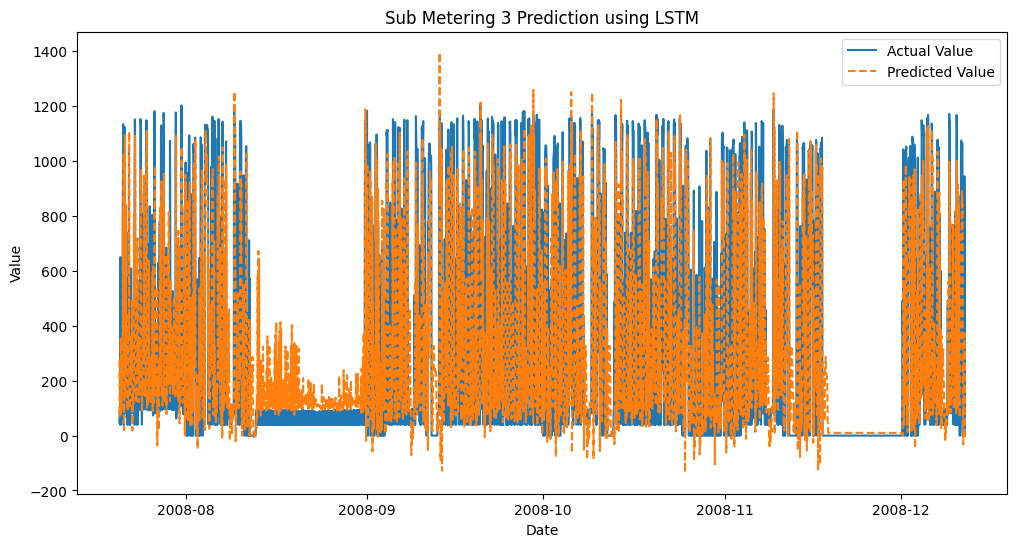

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_agg.index[split_time+sequence_length:], test_target_inverse, label='Actual Value')
plt.plot(df_agg.index[split_time+sequence_length:], predictions, label='Predicted Value', linestyle='dashed')
plt.title('Sub Metering 3 Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Create DataFrame for actual and predicted values
df_results = pd.DataFrame({'Actual Value': test_target_inverse.flatten(), 'Predicted Value': predictions.flatten()})

In [ ]:
# Display the results
print(df_results)

      Actual Value  Predicted Value
0             47.0       273.009277
1             88.0        70.920952
2             90.0       102.173050
3             40.0        93.024384
4            650.0        76.736107
...            ...              ...
3458           0.0       115.792252
3459           0.0       219.498413
3460         945.0       326.622833
3461         792.0       372.842621
3462           0.0       -13.423737

[3463 rows x 2 columns]


# 5 Generate Save Model

## Save the Model

In [73]:
run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
STEPS = 1
INPUT_SIZE = 24
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "model_kWh_3"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

## Convert the Model to TFLITE

In [75]:
import pathlib
tflite_model_file = pathlib.Path('model_kWh_3.tflite')
tflite_model_file.write_bytes(tflite_model)

212216